## init

In [8]:
import numpy as np
import astropy
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astropy.table import join
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import astropy.cosmology.units as cu
from astropy.coordinates import SkyCoord
from scipy.optimize import linear_sum_assignment
import all_fctns

Source_dir ="C:\\Users\\mspan\\OneDrive - The University of Sydney (Students)\\Honours\\Honours Project\\"
catalogue_filepath = Source_dir + "Catalogues\\"
SAMI_regions = ("Cluster", "Filler", "GAMA")
SAMI_spectra_catalogue = "EmissionLine1compDR3.fits"
SAMI_SFR_catalogue = "AR2022_SAMI_DR3_Mstar_SFR_GSWL_rescaled.fits"
SAMI_AGN_summary_catalogue = "Crossmatched\\SAMI_AGN_matches.fits"

def refresh_module():
    import importlib
    import all_fctns
    importlib.reload(all_fctns)

with fits.open(Source_dir +"Catalogues\\Crossmatched\\SAMI_AGN_matches.fits") as SAMI_AGN_matches_hdul:
    Summary_table_hdu = Table(SAMI_AGN_matches_hdul[1].data)

## minimising fctns

In [9]:
def minimising_fctn(parameter_table1, parameter_table2, mass_colname='M_STAR', SFR_colname='SFR_SAMI', match_single_to_multiple=False, log_scale =False):
    """
    Function to minimise the difference between two parameter tables.
    """
   
    m1 = parameter_table1[mass_colname]
    m2 = parameter_table2[mass_colname]

    SFR1 = parameter_table1[SFR_colname]
    SFR2 = parameter_table2[SFR_colname]

    if log_scale:
        m1 = 10**m1
        m2 = 10**m2
        SFR1 = 10**SFR1
        SFR2 = 10**SFR2


    if match_single_to_multiple: # If matching a single galaxy to multiple, need to 'extend the first table so it has the same number of rows as the second table.
        m1 = np.repeat(m1, len(parameter_table2))
        SFR1 = np.repeat(parameter_table1[SFR_colname], len(parameter_table2))


    m_sqrdiff_normalised = ( (m1-m2 ))**2
    SFR_sqrdiff_normalised = ( (SFR1-SFR2) )**2

    weighting_factors = (1, 1)
    
    diff = np.sqrt(weighting_factors[0] * m_sqrdiff_normalised + weighting_factors[1] * SFR_sqrdiff_normalised)
    return diff


def get_closest_galaxy_match(summary_table, input_CATID, possible_CATIDs, mass_colname='M_STAR', SFR_colname='SFR_SAMI', log_scale=True):
    """
    Function to find the closest galaxy match in the summary table based on mass and SFR.
    """

    input_galaxy = summary_table[summary_table['CATID'] == input_CATID]
    
    if len(input_galaxy) == 0:
        print(f"Input CATID {input_CATID} not found in summary table.")
        return None
    
    reduced_summary_table = summary_table[np.isin(summary_table['CATID'], possible_CATIDs)]

    diff_array = minimising_fctn(input_galaxy, reduced_summary_table, mass_colname, SFR_colname, match_single_to_multiple=True, log_scale=log_scale)

    if np.all(np.isnan(diff_array)):
        print("All differences are NaN. No valid matches found.")
        return None

    min_diff = np.nanmin(diff_array)
    closest_match_index = np.nanargmin(diff_array)
    closest_match_CATID = reduced_summary_table['CATID'][closest_match_index]

    return closest_match_CATID, min_diff


def get_multiple_galaxy_matches(summary_table, input_CATIDs, possible_CATIDs, mass_colname='M_STAR', SFR_colname='SFR_SAMI', log_scale=True):
    """
    Matches each galaxy in set A to one in set B, minimizing a cost function based on mass and SFR.
    """



    N = len(input_CATIDs)
    M = len(possible_CATIDs)

    cost_matrix = np.zeros((N, M))

    # Default cost function: Euclidean distance in log space
    for i in range(N):
        cost_matrix[i, :] = minimising_fctn(summary_table[summary_table['CATID'] == input_CATIDs[i]],
                                             summary_table[np.isin(summary_table['CATID'], possible_CATIDs)],
                                             mass_colname=mass_colname, SFR_colname=SFR_colname, match_single_to_multiple=True, log_scale=log_scale)


    # Solve assignment problem (Hungarian algorithm)
    indices_A, indices_B = linear_sum_assignment(cost_matrix)

    matched_galaxies_table =  Table(names=('Input_CATID', 'Matched_CATID', 'min_diff'), dtype=(int, int, float))

    for i, j in zip(indices_A, indices_B):
        matched_galaxies_table.add_row((input_CATIDs[i], possible_CATIDs[j], cost_matrix[i, j]))

    return matched_galaxies_table


In [10]:
test_CATID = Summary_table_hdu[1]['CATID']
print(test_CATID)

matched_CATID = get_closest_galaxy_match(Summary_table_hdu, test_CATID, Summary_table_hdu['CATID'], mass_colname='M_STAR', SFR_colname='SFR_SAMI')


6837
All differences are NaN. No valid matches found.


# Valid Galaxies Bar Plot

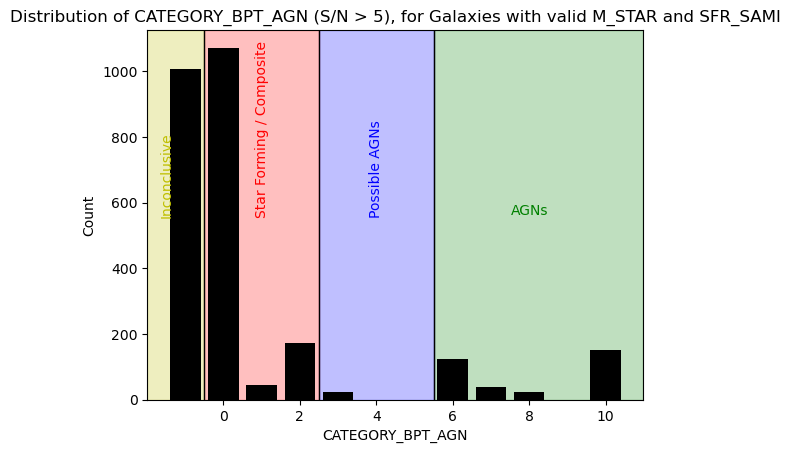

In [11]:


na_mask = np.isnan(Summary_table_hdu['M_STAR']) | np.isnan(Summary_table_hdu['SFR_SAMI'])
valid_Summary_table_hdu = Summary_table_hdu[~na_mask]

# Get the column as a numpy array
categories = np.array(valid_Summary_table_hdu['CATEGORY_BPT_AGN'])

# Count occurrences of each unique value
unique, counts = np.unique(categories, return_counts=True)
# remove weird 999999 value
mask = unique != 999999
unique = unique[mask]
counts = counts[mask]

# Create the bar plot
plt.bar(unique, counts)
plt.xlabel('CATEGORY_BPT_AGN')
plt.ylabel('Count')
plt.title('Distribution of CATEGORY_BPT_AGN (S/N > 5), for Galaxies with valid M_STAR and SFR_SAMI')

xlims = plt.xlim()
ylims = plt.ylim()

plt.xlim(xlims[0], xlims[1])
plt.ylim(ylims[0], ylims[1])

plt.axvline(x=5.5, color='black', linewidth=1)
plt.fill_betweenx([0, ylims[1]], 5.5, xlims[1], color='g', alpha=0.25, label='AGNs')
plt.text(8, 0.5*ylims[1], 'AGNs', color='g', fontsize=10, ha='center')

plt.axvline(x=2.5, color='black', linewidth=1)
plt.fill_betweenx([0, ylims[1]], 2.5, 5.5, color='b', alpha=0.25, label='Possible AGNs')
plt.text(4, 0.5*ylims[1], 'Possible AGNs', color='b', fontsize=10, ha='center', rotation='vertical')

plt.axvline(x=-0.5, color='black', linewidth=1)
plt.fill_betweenx([0, ylims[1]], -0.5, 2.5, color='r', alpha=0.25, label='Star Forming / Composite')
plt.text(1, 0.5*ylims[1], 'Star Forming / Composite', color='r', fontsize=10, ha='center', rotation='vertical')

plt.fill_betweenx([0, ylims[1]], xlims[0], -0.5, color='y', alpha=0.25, label='Inconclusive')
plt.text(-1.5, 0.5*ylims[1], 'Inconclusive', color='y', fontsize=10, ha='center', rotation='vertical')

plt.bar(unique, counts, color='black')

plt.show()

# M_STAR v SAMI_SFR Scatter Plot

### basic plot

Text(0, 0.5, 'SFR_SAMI')

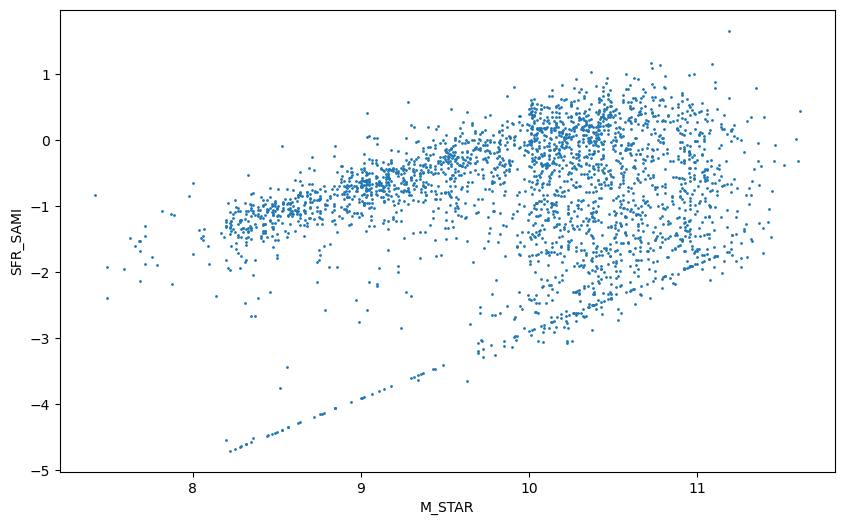

In [12]:
M_STAR_array = valid_Summary_table_hdu['M_STAR']
SFR_SAMI_array = valid_Summary_table_hdu['SFR_SAMI']

plt.figure(figsize=(10, 6))
plt.scatter(M_STAR_array, SFR_SAMI_array, s=1)

plt.xlabel('M_STAR')
plt.ylabel('SFR_SAMI')

### AGN, HII/Composite Labels

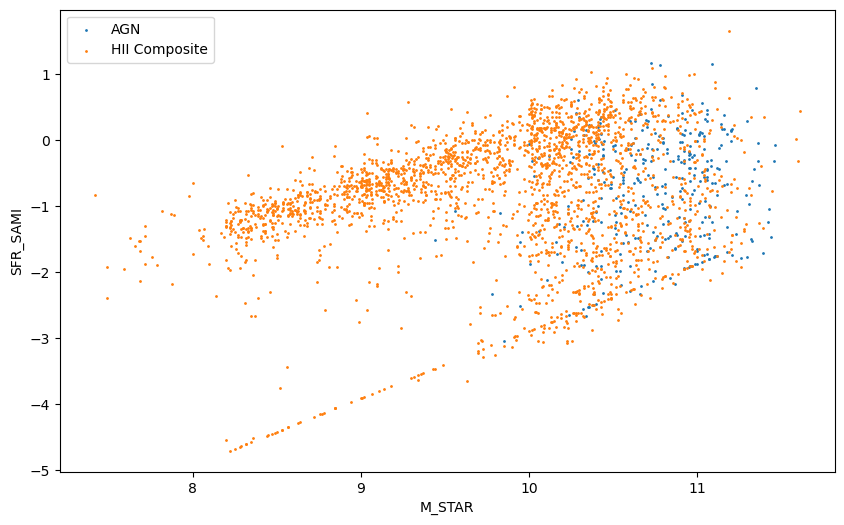

In [13]:
M_STAR_array = valid_Summary_table_hdu['M_STAR']
SFR_SAMI_array = valid_Summary_table_hdu['SFR_SAMI']

AGN_CATIDs = valid_Summary_table_hdu['CATID'][np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], (6, 7, 8, 9, 10))]
HII_Composite_CATIDs = valid_Summary_table_hdu['CATID'][np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], (-1, 0, 1, 2))]

AGN_CATID_mask = np.isin(valid_Summary_table_hdu['CATID'], AGN_CATIDs)
HII_Composite_CATID_mask = np.isin(valid_Summary_table_hdu['CATID'], HII_Composite_CATIDs)

plt.figure(figsize=(10, 6))
plt.scatter(M_STAR_array[AGN_CATID_mask], SFR_SAMI_array[AGN_CATID_mask], s=1, label='AGN')
plt.scatter(M_STAR_array[HII_Composite_CATID_mask], SFR_SAMI_array[HII_Composite_CATID_mask], s=1, label='HII Composite')

plt.xlabel('M_STAR')
plt.ylabel('SFR_SAMI')

plt.legend()

C:\Users\mspan\AppData\Local\Temp\ipykernel_43340\2951424964.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ SFR_SAMI_array[AGN_CATID_mask], SFR_SAMI_array[HII_Composite_CATID_mask] ] , labels=('AGN','HII Composite') )
C:\Users\mspan\AppData\Local\Temp\ipykernel_43340\2951424964.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


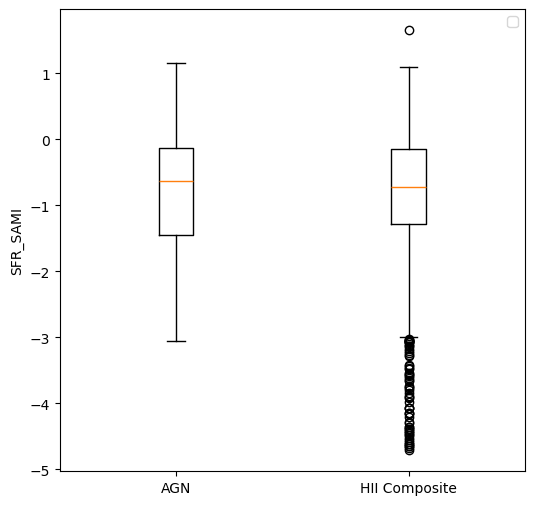

In [14]:
plt.figure(figsize=(6, 6))

plt.boxplot([ SFR_SAMI_array[AGN_CATID_mask], SFR_SAMI_array[HII_Composite_CATID_mask] ] , labels=('AGN','HII Composite') )
plt.ylabel('SFR_SAMI')

plt.legend()

C:\Users\mspan\AppData\Local\Temp\ipykernel_43340\1056694174.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ M_STAR_array[AGN_CATID_mask], M_STAR_array[HII_Composite_CATID_mask] ] , labels=('AGN','HII Composite') )
C:\Users\mspan\AppData\Local\Temp\ipykernel_43340\1056694174.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


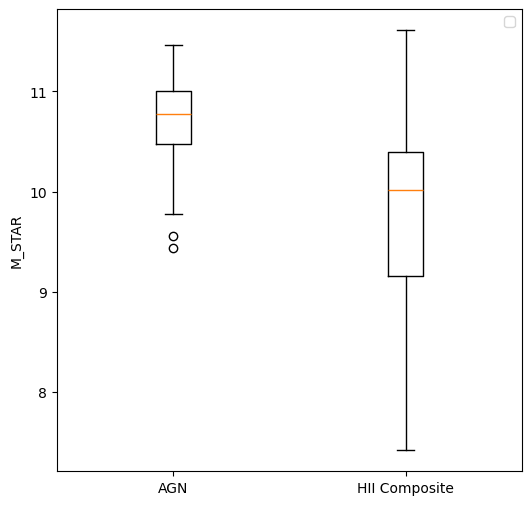

In [15]:
plt.figure(figsize=(6, 6))

plt.boxplot([ M_STAR_array[AGN_CATID_mask], M_STAR_array[HII_Composite_CATID_mask] ] , labels=('AGN','HII Composite') )
plt.ylabel('M_STAR')

plt.legend()

# AGN Matches (Simple)

In [16]:
na_mask = np.isnan(Summary_table_hdu['M_STAR']) | np.isnan(Summary_table_hdu['SFR_SAMI'])
valid_Summary_table_hdu = Summary_table_hdu[~na_mask]

AGN_CATIDs = valid_Summary_table_hdu['CATID'][np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], (6, 7, 8, 9, 10))]

HII_Composite_CATIDs = valid_Summary_table_hdu['CATID'][np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], (0, 1, 2))]

# create table with AGN CATID and corresponding matched HII Composite CATID
matched_AGN_HII_Composite = Table(names=('AGN_CATID', 'HII_Composite_CATID', 'min_diff'), dtype=(int, int, float))

for AGN_CATID in AGN_CATIDs:
    matched_HII_Composite_CATID, min_diff = get_closest_galaxy_match(valid_Summary_table_hdu, AGN_CATID, HII_Composite_CATIDs, mass_colname='M_STAR', SFR_colname='SFR_SAMI')
    

    if matched_HII_Composite_CATID is not None:
        matched_AGN_HII_Composite.add_row((AGN_CATID, matched_HII_Composite_CATID, min_diff))

matched_AGN_HII_Composite

AGN_CATID,HII_Composite_CATID,min_diff
int64,int64,float64
7139,423270,3.525148763083971
7289,551507,3000786905.970434
7839,91963,2554085337.2704935
7946,381979,0.39713050858351867
7969,9239900256,867696640.0
7992,143735,3.760869154331805
8487,272990,2.9076708185426643
15165,551507,12428771637.627602
17314,227264,1.2727581322289403


### Connected Matches

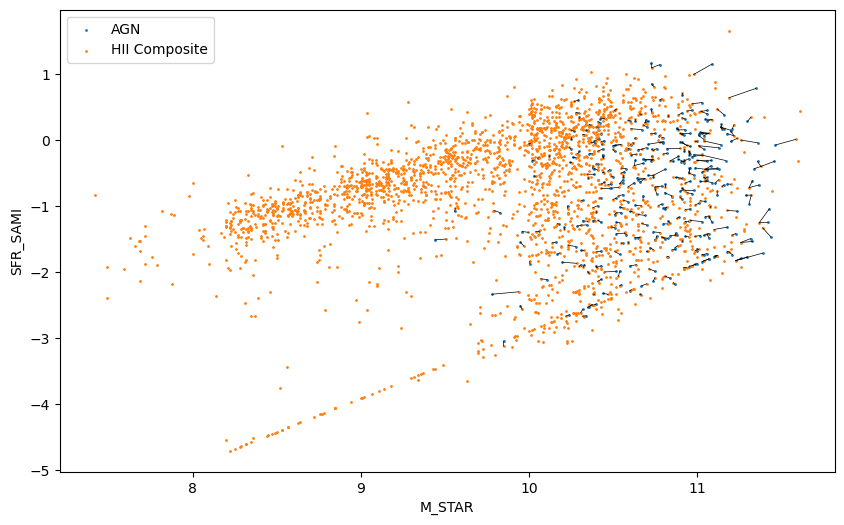

In [17]:
refresh_module()
na_mask = np.isnan(Summary_table_hdu['M_STAR']) | np.isnan(Summary_table_hdu['SFR_SAMI'])
valid_Summary_table_hdu = Summary_table_hdu[~na_mask]

AGN_CATIDs = valid_Summary_table_hdu['CATID'][np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], (6, 7, 8, 9, 10))]

HII_Composite_CATIDs = valid_Summary_table_hdu['CATID'][np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], (-1, 0, 1, 2))]

# create table with AGN CATID and corresponding matched HII Composite CATID
matched_AGN_HII_Composite = Table(names=('AGN_CATID', 'HII_Composite_CATID', 'min_diff'), dtype=(int, int, float))

for AGN_CATID in AGN_CATIDs:
    matched_HII_Composite_CATID, min_diff = all_fctns.get_closest_galaxy_match(valid_Summary_table_hdu, AGN_CATID, HII_Composite_CATIDs, mass_colname='M_STAR', SFR_colname='SFR_SAMI')
    

    if matched_HII_Composite_CATID is not None:
        matched_AGN_HII_Composite.add_row((AGN_CATID, matched_HII_Composite_CATID, min_diff))


M_STAR_array = valid_Summary_table_hdu['M_STAR']
SFR_SAMI_array = valid_Summary_table_hdu['SFR_SAMI']

AGN_CATIDs = valid_Summary_table_hdu['CATID'][np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], (6, 7, 8, 9, 10))]
HII_Composite_CATIDs = valid_Summary_table_hdu['CATID'][np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], (-1, 0, 1, 2))]

AGN_CATID_mask = np.isin(valid_Summary_table_hdu['CATID'], AGN_CATIDs)
HII_Composite_CATID_mask = np.isin(valid_Summary_table_hdu['CATID'], HII_Composite_CATIDs)

plt.figure(figsize=(10, 6))
plt.scatter(M_STAR_array[AGN_CATID_mask], SFR_SAMI_array[AGN_CATID_mask], s=1, label='AGN')
plt.scatter(M_STAR_array[HII_Composite_CATID_mask], SFR_SAMI_array[HII_Composite_CATID_mask], s=1, label='HII Composite')

plt.xlabel('M_STAR')
plt.ylabel('SFR_SAMI')

plt.legend()

# add connected matches
for row in matched_AGN_HII_Composite:
    AGN_CATID = row['AGN_CATID']
    HII_Composite_CATID = row['HII_Composite_CATID']
    
    
    plt.plot([M_STAR_array[valid_Summary_table_hdu['CATID'] == AGN_CATID], M_STAR_array[valid_Summary_table_hdu['CATID'] == HII_Composite_CATID]], 
             [SFR_SAMI_array[valid_Summary_table_hdu['CATID'] == AGN_CATID], SFR_SAMI_array[valid_Summary_table_hdu['CATID'] == HII_Composite_CATID]], 
             'k-', linewidth=0.5)

# AGN Matches (multiple)

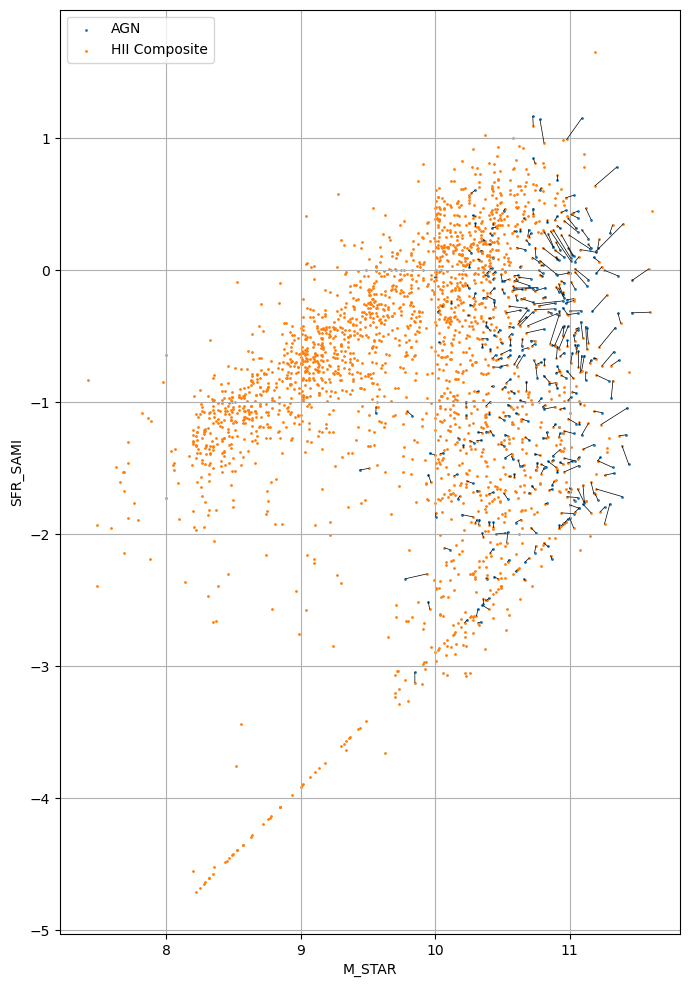

In [18]:
refresh_module()

na_mask = np.isnan(Summary_table_hdu['M_STAR']) | np.isnan(Summary_table_hdu['SFR_SAMI'])
valid_Summary_table_hdu = Summary_table_hdu[~na_mask]

AGN_CATIDs = valid_Summary_table_hdu['CATID'][np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], (6, 7, 8, 9, 10))]

HII_Composite_CATIDs = valid_Summary_table_hdu['CATID'][np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], (-1, 0, 1, 2))]

matched_AGN_HII_Composite = all_fctns.get_multiple_galaxy_matches(valid_Summary_table_hdu, AGN_CATIDs, HII_Composite_CATIDs, mass_colname='M_STAR', SFR_colname='SFR_SAMI', log_scale=False)
matched_AGN_HII_Composite.rename_column('Input_CATID', 'AGN_CATID')
matched_AGN_HII_Composite.rename_column('Matched_CATID', 'HII_Composite_CATID')



M_STAR_array = valid_Summary_table_hdu['M_STAR']
SFR_SAMI_array = valid_Summary_table_hdu['SFR_SAMI']

AGN_CATIDs = valid_Summary_table_hdu['CATID'][np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], (6, 7, 8, 9, 10))]
HII_Composite_CATIDs = valid_Summary_table_hdu['CATID'][np.isin(valid_Summary_table_hdu['CATEGORY_BPT_AGN'], (-1, 0, 1, 2))]

AGN_CATID_mask = np.isin(valid_Summary_table_hdu['CATID'], AGN_CATIDs)
HII_Composite_CATID_mask = np.isin(valid_Summary_table_hdu['CATID'], HII_Composite_CATIDs)

plt.figure(figsize=(8, 12))
plt.grid()

plt.scatter(M_STAR_array[AGN_CATID_mask], SFR_SAMI_array[AGN_CATID_mask], s=1, label='AGN')
plt.scatter(M_STAR_array[HII_Composite_CATID_mask], SFR_SAMI_array[HII_Composite_CATID_mask], s=1, label='HII Composite')

plt.xlabel('M_STAR')
plt.ylabel('SFR_SAMI')

plt.legend()
# add connected matches
for row in matched_AGN_HII_Composite:
    AGN_CATID = row['AGN_CATID']
    HII_Composite_CATID = row['HII_Composite_CATID']
    
    
    plt.plot([M_STAR_array[valid_Summary_table_hdu['CATID'] == AGN_CATID], M_STAR_array[valid_Summary_table_hdu['CATID'] == HII_Composite_CATID]], 
             [SFR_SAMI_array[valid_Summary_table_hdu['CATID'] == AGN_CATID], SFR_SAMI_array[valid_Summary_table_hdu['CATID'] == HII_Composite_CATID]], 
             'k-', linewidth=0.5)



### M_STAR Histogram

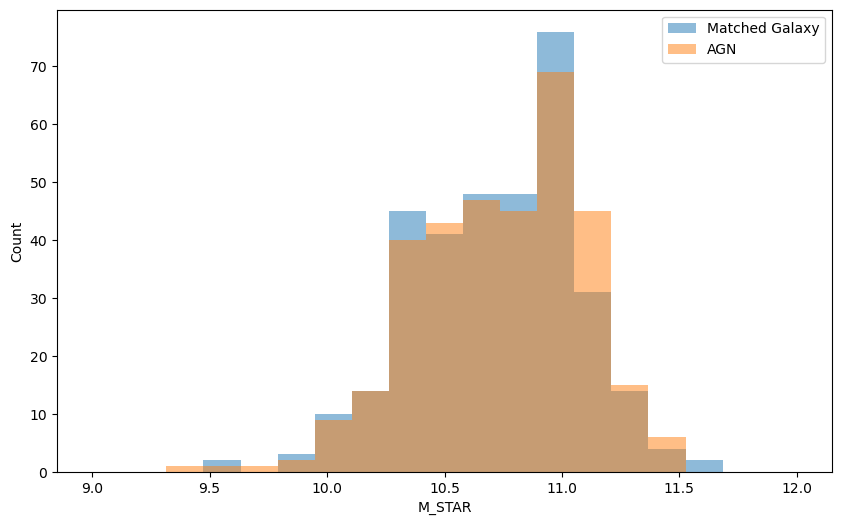

In [19]:
matched_HII_composite_CATIDs = matched_AGN_HII_Composite['HII_Composite_CATID']
matched_AGN_CATIDs = matched_AGN_HII_Composite['AGN_CATID']

bins = np.linspace(9, 12, 20)

plt.figure(figsize=(10, 6))
plt.hist(Summary_table_hdu[np.isin(Summary_table_hdu['CATID'], matched_HII_composite_CATIDs)]['M_STAR'], bins=bins, alpha=0.5, label='Matched Galaxy')
plt.hist(Summary_table_hdu[np.isin(Summary_table_hdu['CATID'], matched_AGN_CATIDs)]['M_STAR'], bins=bins, alpha=0.5, label='AGN')

plt.xlabel('M_STAR')
plt.ylabel('Count')
plt.legend()
plt.show()

### SFR_SAMI Histogram

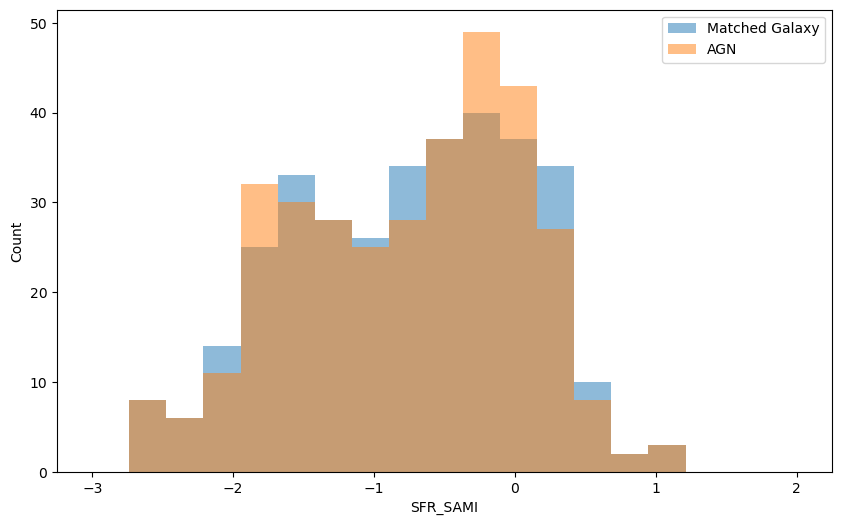

In [20]:
matched_HII_composite_CATIDs = matched_AGN_HII_Composite['HII_Composite_CATID']
matched_AGN_CATIDs = matched_AGN_HII_Composite['AGN_CATID']

bins = np.linspace(-3, 2, 20)
plt.figure(figsize=(10, 6))
plt.hist(Summary_table_hdu[np.isin(Summary_table_hdu['CATID'], matched_HII_composite_CATIDs)]['SFR_SAMI'], bins=bins, alpha=0.5, label='Matched Galaxy')
plt.hist(Summary_table_hdu[np.isin(Summary_table_hdu['CATID'], matched_AGN_CATIDs)]['SFR_SAMI'], bins=bins, alpha=0.5, label='AGN')

plt.xlabel('SFR_SAMI')
plt.ylabel('Count')
plt.legend()
plt.show()